# EXPLORE Data Science Academy Classification Hackathon

© Explore Data Science Academy

---
### Honour Code

I {**RIZQAH, MENIERS**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

#### Overview
South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

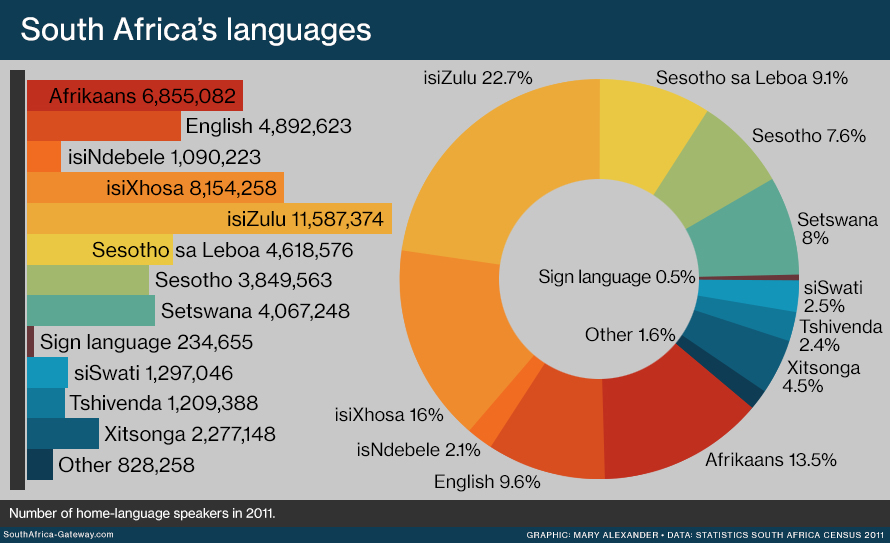


With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, I took text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in

### Importing libraries 

In [1]:
#Data processing, manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Model building
import re
import math
import csv
import string

import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize, TreebankWordTokenizer

from sklearn.svm import LinearSVC
from sklearn import metrics 
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
# Global constants
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Loading Data

In [3]:
#load and show train data
train_df = pd.read_csv('train_set.csv')
train_df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
#load and show test data
test_df = pd.read_csv('test_set.csv')
test_df.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


## TRAIN DATA

### Data Analysis

In [5]:
#Show train column names
train_df.columns

Index(['lang_id', 'text'], dtype='object')

In [6]:
#Train number of rows and columns
train_df.shape

(33000, 2)

In [7]:
#Train data types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


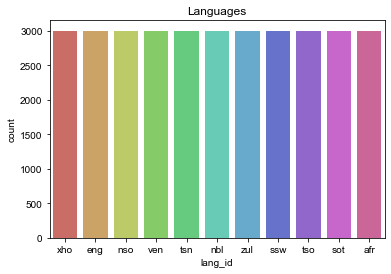

In [8]:
#plot catagorical features
sns.countplot(x = 'lang_id', data = train_df, palette="hls")
sns.set(rc = {'figure.figsize':(10,10)})
plt.title("Languages");

In [9]:
#check value difference
train_df['lang_id'].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

In [10]:
#Show one sentence in full
train_df['text'].iloc[0]

'umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo oluntu lomzantsi afrika'

### Data Preprocessing

In [11]:
#All text characters to lower case
train_df['text'] = train_df['text'].str.lower()

In [12]:
#Function to remove punctuations
def punct(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [13]:
#Apply funtion to new text
train_df['new_text']= train_df['text'].apply(punct)
train_df

,lang_id,text,new_text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...
...,...,...,...
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...,nawuphina umntu ofunyenwe enetyala phantsi kwa...


In [14]:
#Function to remove punctuations
spec_char = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_char:
    train_df['new_text'] = train_df['new_text'].str.replace(char, ' ')

<ipython-input-14-9a5775202596>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_df['new_text'] = train_df['new_text'].str.replace(char, ' ')


In [15]:
train_df.head()

,lang_id,text,new_text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [16]:
train_ndf = train_df.drop(['text'], axis = 1) # Remove original text column
train_ndf

,lang_id,new_text
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...
...,...,...
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...


In [17]:
spec_char = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]

char = 'abcdefghijklmnopqrstuvwxyz123456789 \n'

In [18]:
def spec_char(post):
    return ''.join([l for l in post if l in char])

In [19]:
train_ndf['new_text'] = train_ndf['new_text'].apply(spec_char)

### Data Engineering

In [20]:
#Splitting data into train/test set
X = train_ndf["new_text"]
y = train_ndf["lang_id"]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

In [22]:
print({'xtrain' : X_train.shape})
print({'xtest' : X_test.shape})
print({'ytrain' : y_train.shape})
print({'ytest' : y_test.shape})

{'xtrain': (26400,)}
{'xtest': (6600,)}
{'ytrain': (26400,)}
{'ytest': (6600,)}


### Model Fitting

In [23]:
tfid = TfidfVectorizer()
tfid.fit_transform(X_train)

<26400x126575 sparse matrix of type '<class 'numpy.float64'>'
	with 738826 stored elements in Compressed Sparse Row format>

### Model Building

In [24]:
#Linear SVC model
lin_sv = LinearSVC()

In [25]:
lin_sv.fit(tfid.transform(X_train), y_train)
y_pred = lin_sv.predict(tfid.transform(X_test))

In [26]:
#Accuracy

evalu = (metrics.accuracy_score(y_test, y_pred)) *100
print(evalu, '%')

99.75757575757575 %


In [27]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       567
         eng       1.00      1.00      1.00       611
         nbl       1.00      0.99      0.99       601
         nso       1.00      1.00      1.00       593
         sot       1.00      1.00      1.00       595
         ssw       0.99      1.00      1.00       575
         tsn       1.00      1.00      1.00       619
         tso       1.00      1.00      1.00       588
         ven       1.00      1.00      1.00       632
         xho       1.00      1.00      1.00       597
         zul       0.99      1.00      0.99       622

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



## TEST DATA

### Data Analysis

In [28]:
#Show test column names
test_df.columns

Index(['index', 'text'], dtype='object')

In [29]:
#Test number of rows and columns
test_df.shape

(5682, 2)

In [30]:
#Test data types
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   5682 non-null   int64 
 1   text    5682 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.9+ KB


In [31]:
#Show one sentence in full
test_df['text'].iloc[0]

'Mmasepala, fa maemo a a kgethegileng a letlelela kgato eo.'

In [32]:
#All text characters to lower case
test_df['text'] = test_df['text'].str.lower()

In [33]:
#Apply funtion to to remove punctuations to text
test_df['new_text']= test_df['text'].apply(punct)

In [34]:
test_ndf = test_df.drop(['text'], axis = 1) # Remove original text column

In [35]:
#Apply funtion to to remove special characters to text
test_ndf['new_text'] = test_ndf['new_text'].apply(spec_char)

### Test Prediction

In [36]:
kag_pred = test_ndf['new_text']

In [37]:
final_pred =  lin_sv.predict(tfid.transform(kag_pred))

In [38]:
final_pred.shape

(5682,)

In [39]:
pred = pd.DataFrame(data=test_ndf['index'], columns=['index'])
pred.insert(1, 'lang_id', final_pred)

pred.head()

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr


In [40]:
pred.to_csv('LinearSVCmodel.csv', index=False)